# toolkit

In [209]:
# For google colab: > Edit > Notebook settings > Hardware Accelerator > GPU
!nvidia-smi

Tue Jan 31 21:41:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   74C    P0    29W / 130W |   2005MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [210]:
# # for CUDA 11.6, Windows, Python, pip
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [211]:
import torch
import torchvision

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

from torch.utils.data import random_split

from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
import torch.optim as optim

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import time

# helper fxns

In [213]:
def fc_layer(in_ft, out_ft, activation, *args, **kwargs):
    """
    Inputs: in_ft : int
            -> input features to current nn.Linear layer
            
            out_ft : int
            -> output neurons of current nn.Linear layer

            activation : function
            -> activation to be performed after linear transformation

            **kwargs : dict
            -> dropout_prob : default = 0
    
    Returns: nn.Sequential()
            -> layer of linear->activation->dropout
    
    """
    dropout_prob = kwargs.get('dropout_prob', 0.)

    return nn.Sequential(
        nn.Linear(in_features = in_ft, out_features = out_ft), 
        activation, 
        nn.Dropout(dropout_prob)
    )


class MLP(nn.Module):
    """
    Multilayer perceptron class

    Inputs: in_size : int
            > input layer size (input features to 1st hidden layer)

            out_size : int
            >  output layer size (output features of output layer)

            hl_data : tuple
            > (no. of hidden layers : int, no. of neurons in each layer : int)

            activation : str / function
            > activation function to applied throughout MLP

            **kwargs : dict
            > dropout_prob : float E [0., 1.]
                probability associated to dropout
    """
    def __init__(self, in_size, out_size, hl_data, activation, *args, **kwargs):
        super(MLP, self).__init__()
        
        self.num_layers, self.hl_neurons = hl_data
        self.activation = getattr(nn, activation)()

        dropout_prob = kwargs.get('dropout_prob', 0.)

        #hidden layers
        hl_data = [in_size] + list(hl_data[1] for _ in range(hl_data[0]))
        fc_hl_blocks = [fc_layer(in_n, out_n, self.activation, dropout_prob = dropout_prob) for in_n, out_n in zip(hl_data[:-1], hl_data[1:])]
        

        #output layer
        output_layer = nn.Sequential(
            nn.Linear(in_features = hl_data[-1], out_features = out_size), 
            nn.Softmax(dim = 1) #range(0, 1), sigma(output) = 1
        )

        #mlp
        self.network = nn.Sequential(
            *fc_hl_blocks, 
            output_layer
        )
    

    def forward(self, x):
        flatten_x = torch.flatten(x, 1)
        pred = self.network(flatten_x)
        return pred

In [214]:
def lp_norm_reg(model, reg_p_norm = 2.0, reg_lambda = 0.001, **kwargs):
    """
    Inputs: model : nn.Module
            reg_p_norm : float
                p value in Lp norm
            reg_lambda : float
                regularization coefficient
    
    Returns: regularization loss: 
                summation (Lp norm ^ p)
    """
    lp_norm = sum(
        p[0].abs().pow(reg_p_norm).sum()
        for p in model.parameters()
    )
    lp_norm_loss = lp_norm * reg_lambda

    return lp_norm_loss

In [215]:
def validate(model, device, val_loader, loss_fxn, *args, **kwargs):
    """
    > performs prediction over whole input set batch-wise
    > calculates loss and accuracy

    Inputs: 
        > model : nn.Module
        > device : cuda device type
        > val_loader : data loader
        > loss_fxn : function to calculate loss
        > **kwargs :
            > regularization parameters :
                > reg_fxn, reg_p_norm, reg_lambda
    
    Outputs: 
        > avg. loss per example
        > avg. accuracy per example
    """

    # regularization parameters
    reg_params = ['reg_fxn', 'reg_p_norm', 'reg_lambda']
    reg_kwargs = {k : kwargs.get(k) for k in reg_params}
    reg_fxn = reg_kwargs.get('reg_fxn')

    # variable initialization
    model.eval()
    num_batches = 0
    val_loss, val_acc = 0.0, 0

    # no learning
    with torch.no_grad():
        # batch-wise iteration over dataset
        for i, batch in enumerate(val_loader):
            # extract X, y from batches and feed to device
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass on model to generate outputs
            outputs = model(images)

            # loss over prediction and outputs
            loss = loss_fxn(outputs, labels)

            # adding regularization to loss (if any)
            if reg_fxn != None:
                loss += reg_fxn(model, **reg_kwargs)

            # classifiation accuracy per image (over single batch)
            acc = torch.sum(torch.argmax(outputs, 1) == labels).item() / labels.size(0)

            # adding corresponding loss and accuracy from previous batches
            val_loss += loss.item()
            val_acc += acc

            num_batches = i+1

    # avg. loss and acc. per image (over all batches)
    val_loss = val_loss / num_batches
    val_acc = val_acc / num_batches
    
    return val_loss, val_acc

In [216]:
def fit(model, device, train_loader, num_epochs, optimizer, loss_fxn, val_loader, *args, **kwargs):
    """
    > 
    > performs prediction over whole input set batch-wise
    > calculates loss and accuracy

    Inputs: 
        > model : nn.Module
        > device : cuda device type
        > train_loader : data loader for training
        > num_epochs : how many times to train over whole dataset
        > optimizer : nn.optim
        > loss_fxn : function to calculate loss
        > val_loader : data loader for validation
        > **kwargs :
            > regularization parameters :
                > reg_fxn, reg_p_norm, reg_lambda
    
    Outputs: 
        > training loss and accuracy history
        > valiadation loss and accuracy history
        > weights and gradients matrices
            > shape : [num_epochs, num_layers(model), (tuple of size 2)]
            > tuple contains (mean, std)
    """
    # regularization parameters
    reg_params = ['reg_fxn', 'reg_p_norm', 'reg_lambda']
    reg_kwargs = {k : kwargs.get(k) for k in reg_params}
    reg_fxn = reg_kwargs.get('reg_fxn')

    # history lists initialization
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    weights_history, grads_history = [], []

    # train over full data num_epoch times
    for epoch in range(1, num_epochs + 1):
        # alerts model to be ready for training
        model.train()
        # debug
        print(f'#epoch :: {epoch} / {num_epochs}')
        
        # reset temp variables
        train_loss = 0.0
        train_acc = 0
        num_batches = 0
        weights_list = []
        grads_list = []

        # iterate over all batches
        for i, batch in enumerate(train_loader):
            # batch images and labels
                # sending to device is imp.
                # else model(gpu) and data(cpu) will be on different devices
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            # reset gradients
                # since loss.backward adds over prev. grads
                # therefore resetting after each epoch is necessary
            optimizer.zero_grad()

            # forward propagation
            outputs = model(images)

            # loss calculation
            loss = loss_fxn(outputs, labels)
            if reg_fxn != None:
                loss += reg_fxn(model, **reg_kwargs)
            # backward propagation
            loss.backward()
            # weight updation
            optimizer.step()
            
            # loss over epoch
            train_loss += loss.item()

            #acc over epoch
            acc = torch.sum(torch.argmax(outputs, 1) == labels).item() / labels.size(0)
            train_acc += acc
            
            # current batch length
            num_batches = i+1
        
        # loss history
        train_loss = train_loss / num_batches
        train_losses.append(train_loss)

        # acc history
        train_acc = train_acc / num_batches
        train_accs.append(train_acc)

        # weights history
        for layer in model.network:
            weights = layer[0].weight
            weights_list.append((weights.mean(), weights.std()))

            grads =  weights.grad
            grads_list.append((grads.mean(), grads.std()))
        weights_history.append(weights_list)
        grads_history.append(grads_list)


        # validation history
        val_loss, val_acc = validate(model, device, val_loader, loss_fxn, **reg_kwargs)
        val_losses.append(val_loss)
        val_accs.append(val_acc)


        # debug
        print(f'\ttrain_loss:: {train_loss : .4f},\ttrain_acc:: {train_acc : .4f}')
        print(f'\tval_loss:: {val_loss : .4f},\tval_acc:: {val_acc : .4f}')
    
    fit_history = train_losses, train_accs, val_losses, val_accs, weights_history, grads_history
    return fit_history

# Question 1

## import dataset

In [217]:
_tasks = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
    ])

In [218]:
# import train & test data
trainset = CIFAR10(
    root = './data', 
    train = True, 
    download = True, 
    transform = _tasks
)

testset = CIFAR10(
    root = './data', 
    train = False, 
    download = True, 
    transform = _tasks
)

Files already downloaded and verified
Files already downloaded and verified


In [219]:
num_class_labels = len(trainset.classes)
img_size = torch.numel(trainset[0][0])

print(num_class_labels, img_size)

10 1024


### data summary

In [220]:
# dataset summary
print('trainset summary:', trainset, '\n\n')
print('testset summary:', testset, '\n\n')

trainset summary: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) 


testset summary: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) 




In [221]:
# 50k examples, 32x32 size, 3 channels (RGB)
# 10k examples, 32x32 size, 3 channels (RGB)
# 10 image classes
print('trainset data shape:', trainset.data.shape)
print('testset data shape:', testset.data.shape)
print('class labels', f'({len(trainset.classes)}):' , trainset.classes)

trainset data shape: (50000, 32, 32, 3)
testset data shape: (10000, 32, 32, 3)
class labels (10): ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [222]:
# 50k examples
# tuple -> (tensor, class label)
        # tensor -> image (3, 32, 32)

print('trainset length:', len(trainset))
print('1st trainset example:', trainset[0])
print('1st trainset tensor shape:', trainset[0][0].shape)

trainset length: 50000
1st trainset example: (tensor([[[0.2392, 0.1765, 0.1882,  ..., 0.5373, 0.5098, 0.5059],
         [0.0745, 0.0000, 0.0392,  ..., 0.3725, 0.3529, 0.3686],
         [0.0941, 0.0353, 0.1216,  ..., 0.3529, 0.3569, 0.3137],
         ...,
         [0.6784, 0.6039, 0.6157,  ..., 0.5255, 0.1412, 0.1490],
         [0.5725, 0.5059, 0.5647,  ..., 0.6000, 0.2706, 0.2353],
         [0.5922, 0.5373, 0.5765,  ..., 0.7412, 0.4863, 0.3882]]]), 6)
1st trainset tensor shape: torch.Size([1, 32, 32])


## train-validation split

In [223]:
## train, validation split
val_fraction = 0.2

val_size = int(val_fraction * len(trainset))
train_size = len(trainset) - val_size

train_set, val_set = random_split(trainset, [train_size, val_size])


print('train_set size:', len(train_set), 'val_set size:', len(val_set))

train_set size: 40000 val_set size: 10000


## batch creation

In [224]:
# iterable batch creation
batch_kwargs = {
    'batch_size' : 1024, 
    'num_workers' : 0,
    'pin_memory' : True
}
train_loader = DataLoader(train_set, shuffle=True, **batch_kwargs)
val_loader = DataLoader(val_set, **batch_kwargs)
test_loader = DataLoader(testset, **batch_kwargs)

print('batch_params:', batch_kwargs)

batch_params: {'batch_size': 1024, 'num_workers': 0, 'pin_memory': True}


## activation comparison

In [232]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

hl_data = (3, 256)
loss_fxn = nn.CrossEntropyLoss()
num_epochs = 10

#  activations comparision


activations = ['Sigmoid', 'Tanh', 'ReLU', 'LeakyReLU']
fit_hist_activationWise = []
runtimes = [] # training time avg. over total epochs

for activation in activations:
    print('-'*50, 'activation:', str(activation))
    temp_model = MLP(input_size, output_size, hl_data, activation).to(device)
    print(temp_model.network)
    temp_optimizer = optim.Adam(temp_model.parameters(), lr=1e-3)

    
    start_time = time.time()
    temp_train_hist = fit(temp_model, device, train_loader, num_epochs, temp_optimizer, loss_fxn, val_loader)
    print("--- %s seconds ---" % (time.time() - start_time))
    runtimes.append((time.time() - start_time) / num_epochs)
    
    fit_hist_activationWise.append(temp_train_hist)

-------------------------------------------------- activation: Sigmoid
Sequential(
  (0): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.0, inplace=False)
  )
  (1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.0, inplace=False)
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.0, inplace=False)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
#epoch :: 1 / 10
	train_loss::  2.2937,	train_acc::  0.1278
	val_loss::  2.2698,	val_acc::  0.1565
#epoch :: 2 / 10
	train_loss::  2.2610,	train_acc::  0.1647
	val_loss::  2.2536,	val_acc::  0.1852
#epoch :: 3 / 10
	train_loss::  2.2425,	train_acc::  0.2016
	val_loss::  2.2388,	val_acc::  0.2071
#epoch :: 4 / 10
	train_loss::  2.2230,	train_acc::  0.2281
	val_loss::  2.2204,

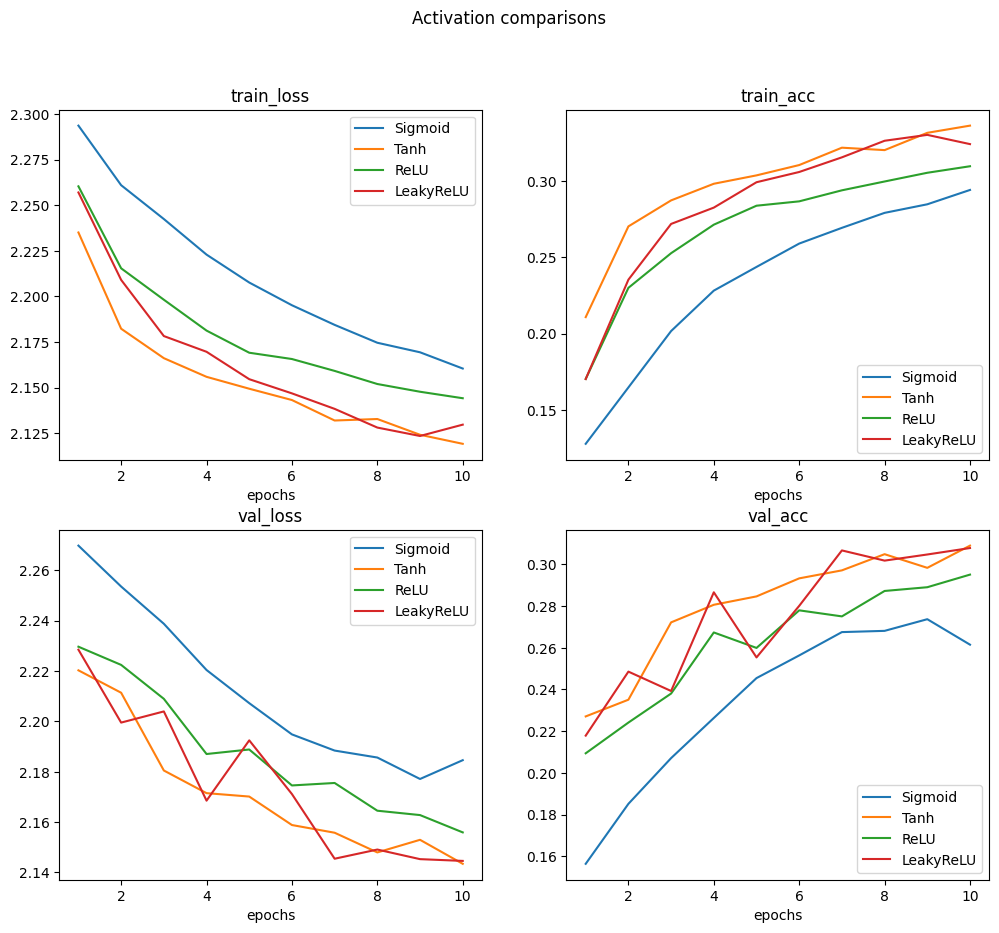

In [233]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
x_axis = list(range(1, num_epochs+1))
for i, fit_hist in enumerate(fit_hist_activationWise):
    ax[0, 0].plot(x_axis, fit_hist[0], label = str(activations[i]))
    ax[0, 1].plot(x_axis, fit_hist[1], label = str(activations[i]))
    ax[1, 0].plot(x_axis, fit_hist[2], label = str(activations[i]))
    ax[1, 1].plot(x_axis, fit_hist[3], label = str(activations[i]))

ax[0, 0].set_title('train_loss')
ax[0, 1].set_title('train_acc')
ax[1, 0].set_title('val_loss')
ax[1, 1].set_title('val_acc')


ax[0, 0].set_xlabel('epochs')
ax[0, 1].set_xlabel('epochs')
ax[1, 0].set_xlabel('epochs')
ax[1, 1].set_xlabel('epochs')


ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
plt.suptitle('Activation comparisons')

plt.show()

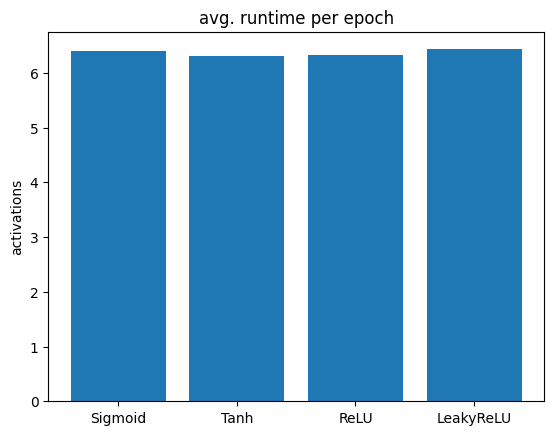

In [234]:
plt.bar(activations, runtimes)
plt.title('avg. runtime per epoch')
plt.ylabel('seconds')
plt.ylabel('activations')
plt.show()

## vanishing gradient

In [235]:
## vanishing gradient problem in sigmoid activation
activation = 'Sigmoid' # ['Sigmoid', 'Tanh', 'ReLu, 'LeakyReLu']


input_size = img_size
output_size = num_class_labels
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("device::",  device)

loss_fxn = nn.CrossEntropyLoss()
num_epochs = 10

max_depth = 10 # max no. of layers
num_neurons = 256 # num neurons in each hiddden layer

# fitting history storage
train_losses_depthwise_1, train_accs_depthwise_1 = [], []
val_losses_depthwise_1, val_accs_depthwise_1 = [], []
weights_hist_depthwise_1 = []
grads_hist_depthwise_1 = []

for depth in range(max_depth):
    print('-'*50, 'depth:', depth+1)
    temp_model = MLP(input_size, output_size, (depth, num_neurons), activation).to(device)
    optimizer = optim.Adam(temp_model.parameters(), lr=1e-3)
    # print(temp_model)
    fit_history = fit(temp_model, device, train_loader, num_epochs, optimizer, loss_fxn, val_loader)
    ## fit_history = train_loss, train_acc, val_loss, val_acc, weights_hist, grads_hist

    train_losses_depthwise_1.append(fit_history[0])
    train_accs_depthwise_1.append(fit_history[1])
    val_losses_depthwise_1.append(fit_history[2])
    val_accs_depthwise_1.append(fit_history[3])
    weights_hist_depthwise_1.append(fit_history[4])
    grads_hist_depthwise_1.append(fit_history[5])
    

device:: cuda:0
-------------------------------------------------- depth: 1
#epoch :: 1 / 10
	train_loss::  2.2653,	train_acc::  0.1803
	val_loss::  2.2418,	val_acc::  0.2226
#epoch :: 2 / 10
	train_loss::  2.2232,	train_acc::  0.2510
	val_loss::  2.2190,	val_acc::  0.2493
#epoch :: 3 / 10
	train_loss::  2.2046,	train_acc::  0.2688
	val_loss::  2.2056,	val_acc::  0.2625
#epoch :: 4 / 10
	train_loss::  2.1934,	train_acc::  0.2808
	val_loss::  2.1972,	val_acc::  0.2746
#epoch :: 5 / 10
	train_loss::  2.1858,	train_acc::  0.2848
	val_loss::  2.1954,	val_acc::  0.2646
#epoch :: 6 / 10
	train_loss::  2.1845,	train_acc::  0.2817
	val_loss::  2.1899,	val_acc::  0.2782
#epoch :: 7 / 10
	train_loss::  2.1793,	train_acc::  0.2900
	val_loss::  2.1931,	val_acc::  0.2661
#epoch :: 8 / 10
	train_loss::  2.1775,	train_acc::  0.2856
	val_loss::  2.1869,	val_acc::  0.2751
#epoch :: 9 / 10
	train_loss::  2.1736,	train_acc::  0.2925
	val_loss::  2.1837,	val_acc::  0.2781
#epoch :: 10 / 10
	train_loss::  

## vanishing gradient solution

In [236]:
## solving vanishing gradient using ReLU
activation = 'ReLU' # ['Sigmoid', 'Tanh', 'ReLu, 'LeakyReLu']


input_size = img_size
output_size = num_class_labels
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("device::",  device)

loss_fxn = nn.CrossEntropyLoss()
num_epochs = 10

max_depth = 10
num_neurons = 256

# fitting history
train_losses_depthwise_2, train_accs_depthwise_2 = [], []
val_losses_depthwise_2, val_accs_depthwise_2 = [], []
weights_hist_depthwise_2 = []
grads_hist_depthwise_2 = []

for depth in range(max_depth):
    print('-'*50, 'depth:', depth+1)
    temp_model = MLP(input_size, output_size, (depth, num_neurons), activation).to(device)
    optimizer = optim.Adam(temp_model.parameters(), lr=1e-3)
    # print(temp_model)
    fit_history = fit(temp_model, device, train_loader, num_epochs, optimizer, loss_fxn, val_loader)
    ## fit_history = train_loss, train_acc, val_loss, val_acc, weights_hist, grads_hist

    train_losses_depthwise_2.append(fit_history[0])
    train_accs_depthwise_2.append(fit_history[1])
    val_losses_depthwise_2.append(fit_history[2])
    val_accs_depthwise_2.append(fit_history[3])
    weights_hist_depthwise_2.append(fit_history[4])
    grads_hist_depthwise_2.append(fit_history[5])

device:: cuda:0
-------------------------------------------------- depth: 1
#epoch :: 1 / 10
	train_loss::  2.2647,	train_acc::  0.1825
	val_loss::  2.2399,	val_acc::  0.2349
#epoch :: 2 / 10
	train_loss::  2.2233,	train_acc::  0.2480
	val_loss::  2.2194,	val_acc::  0.2501
#epoch :: 3 / 10
	train_loss::  2.2060,	train_acc::  0.2657
	val_loss::  2.2067,	val_acc::  0.2623
#epoch :: 4 / 10
	train_loss::  2.1956,	train_acc::  0.2781
	val_loss::  2.2005,	val_acc::  0.2699
#epoch :: 5 / 10
	train_loss::  2.1892,	train_acc::  0.2806
	val_loss::  2.1960,	val_acc::  0.2723
#epoch :: 6 / 10
	train_loss::  2.1836,	train_acc::  0.2867
	val_loss::  2.1912,	val_acc::  0.2757
#epoch :: 7 / 10
	train_loss::  2.1798,	train_acc::  0.2929
	val_loss::  2.1901,	val_acc::  0.2781
#epoch :: 8 / 10
	train_loss::  2.1778,	train_acc::  0.2901
	val_loss::  2.1872,	val_acc::  0.2797
#epoch :: 9 / 10
	train_loss::  2.1760,	train_acc::  0.2894
	val_loss::  2.1855,	val_acc::  0.2785
#epoch :: 10 / 10
	train_loss::  

## vanishing gradient comparison

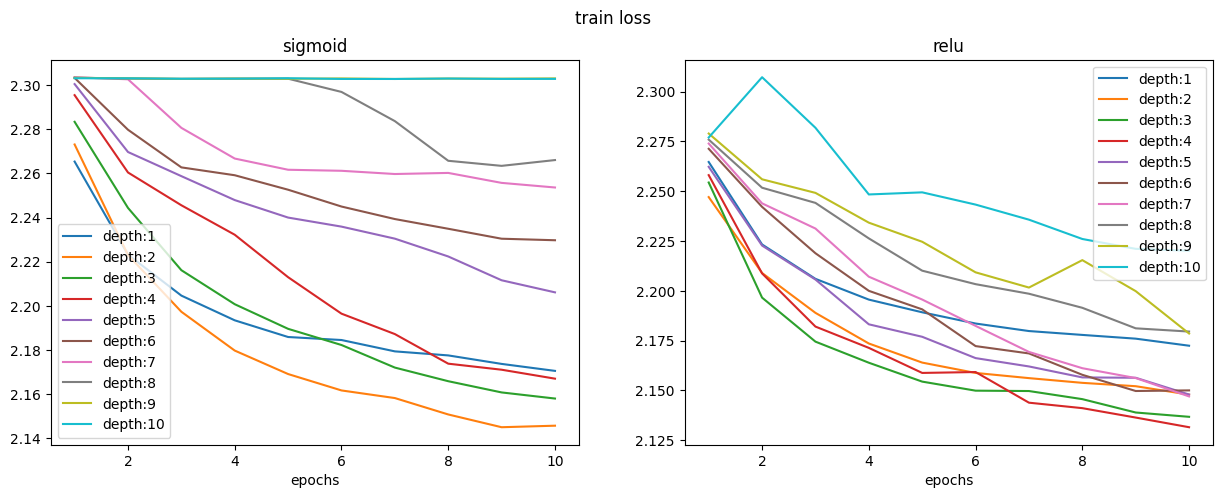

In [237]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
x_axis = list(range(1, num_epochs + 1))

ax[0].plot(x_axis, np.array(train_losses_depthwise_1).T)
ax[1].plot(x_axis, np.array(train_losses_depthwise_2).T)

ax[0].set_title('sigmoid')
ax[0].set_xlabel('epochs')
ax[0].legend(['depth:' + str(i+1) for i in range(max_depth)])

ax[1].set_title('relu')
ax[1].set_xlabel('epochs')
ax[1].legend(['depth:' + str(i+1) for i in range(max_depth)])
plt.suptitle('train loss')
plt.show()

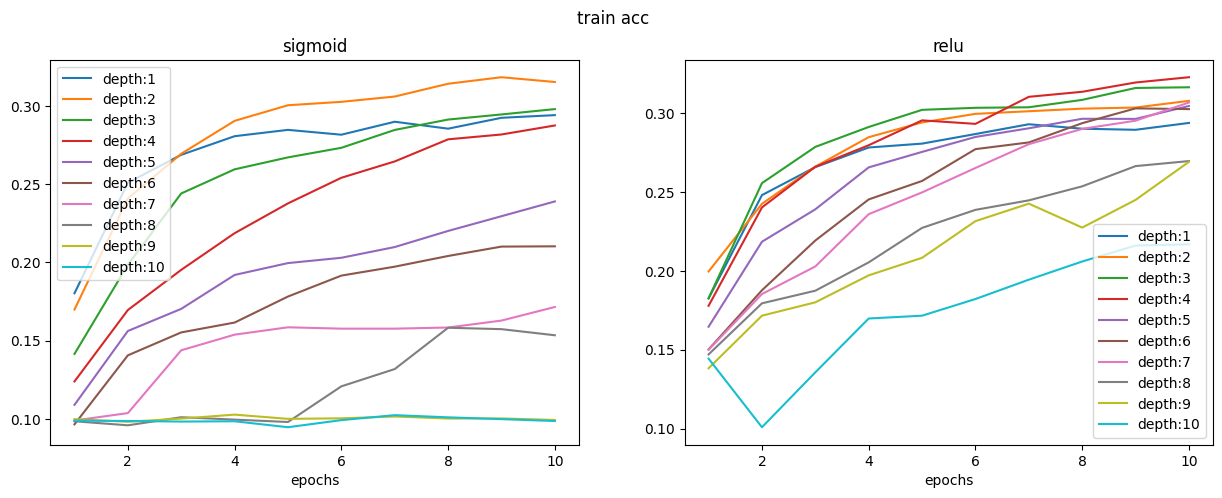

In [238]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
x_axis = list(range(1, num_epochs + 1))

ax[0].plot(x_axis, np.array(train_accs_depthwise_1).T)
ax[1].plot(x_axis, np.array(train_accs_depthwise_2).T)

ax[0].set_title('sigmoid')
ax[0].set_xlabel('epochs')
ax[0].legend(['depth:' + str(i+1) for i in range(max_depth)])

ax[1].set_title('relu')
ax[1].set_xlabel('epochs')
ax[1].legend(['depth:' + str(i+1) for i in range(max_depth)])
plt.suptitle('train acc')
plt.show()

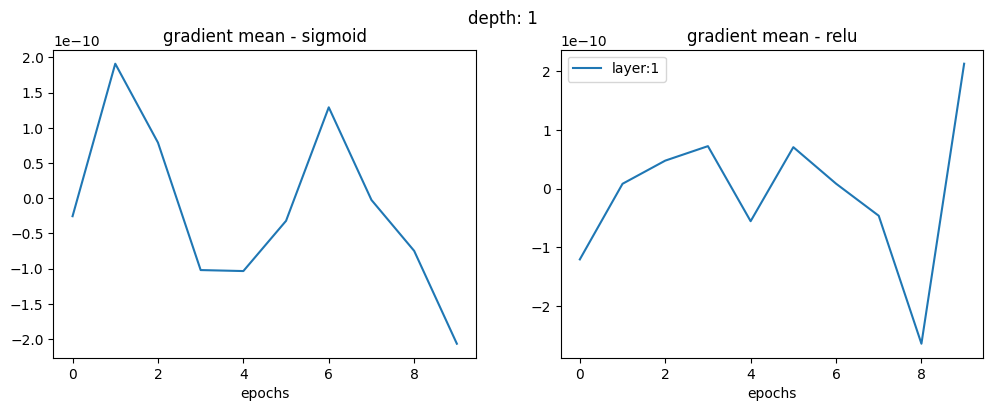

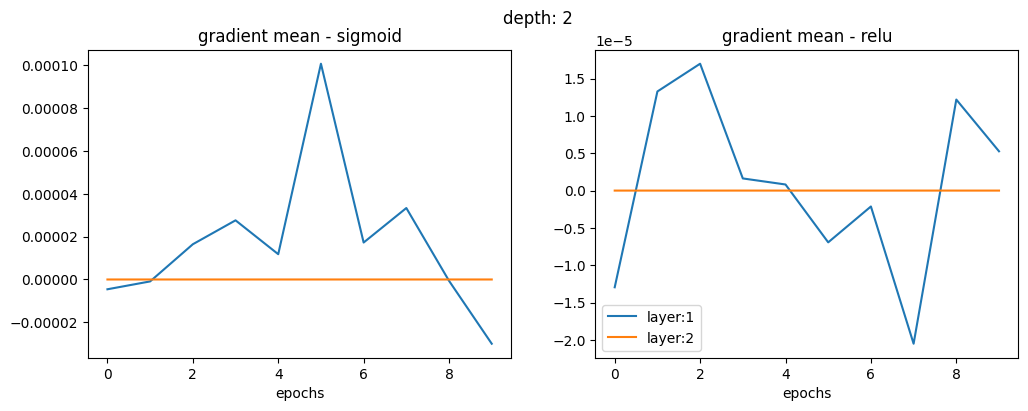

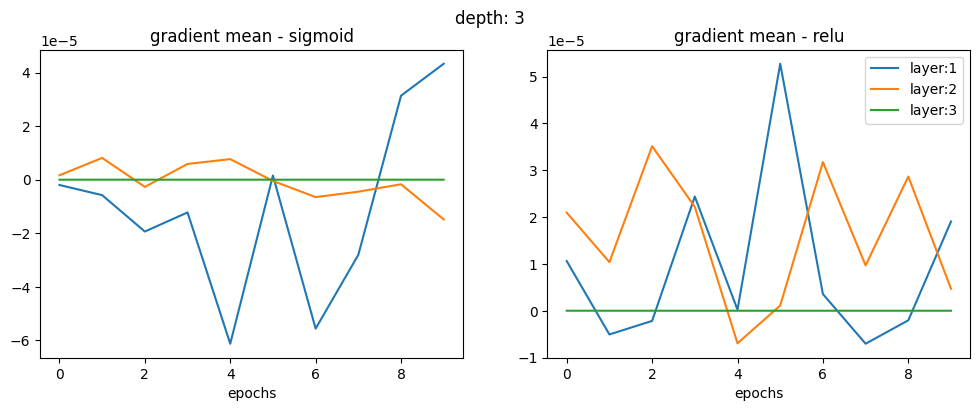

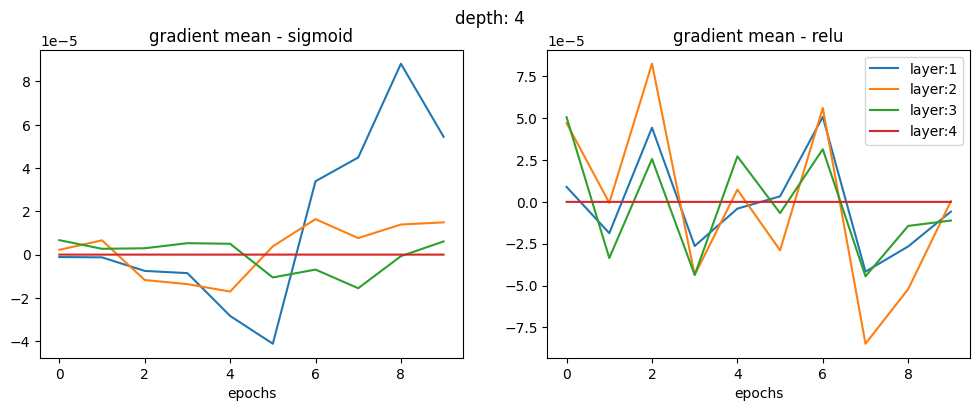

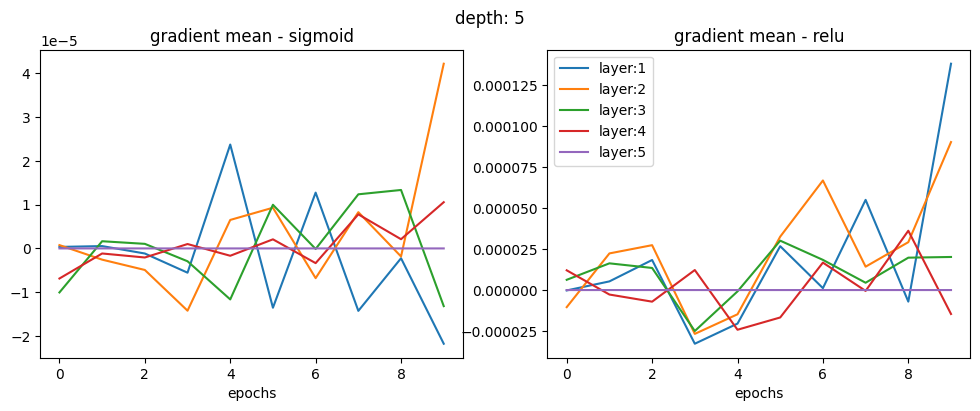

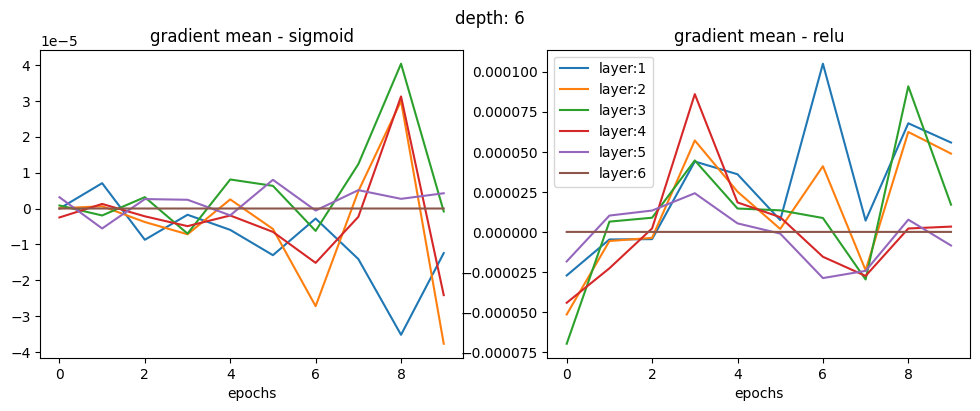

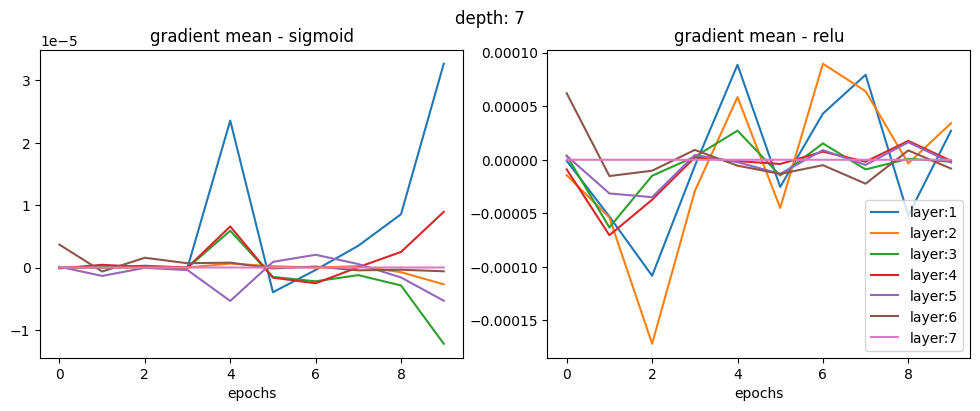

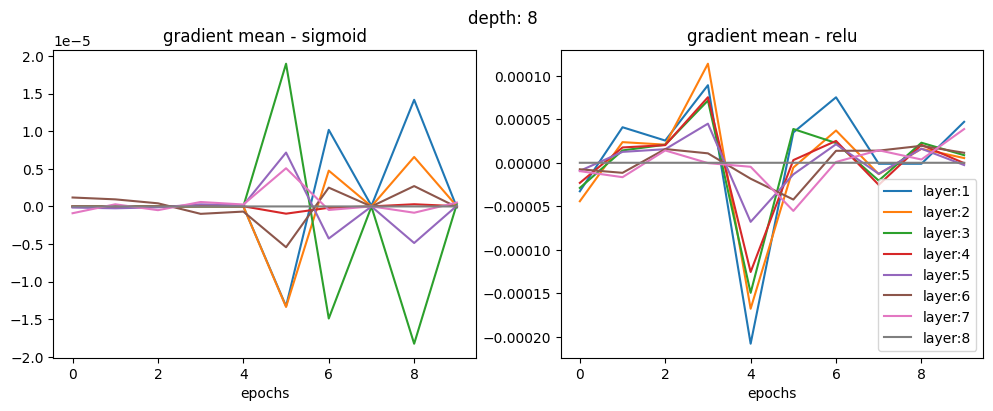

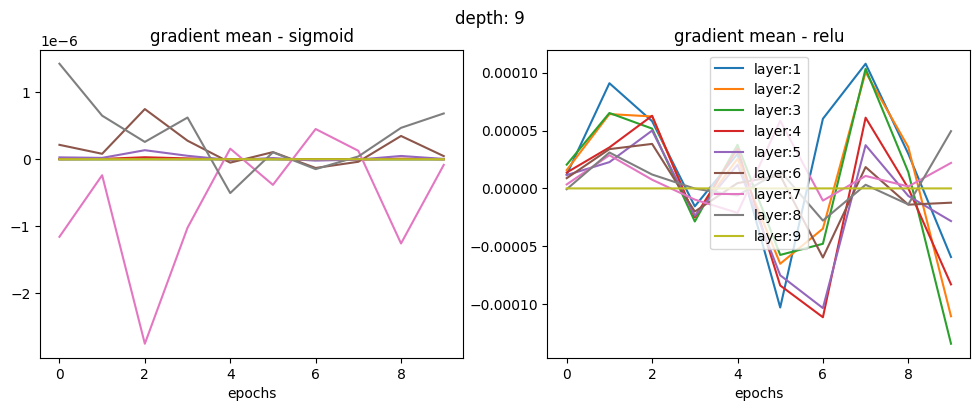

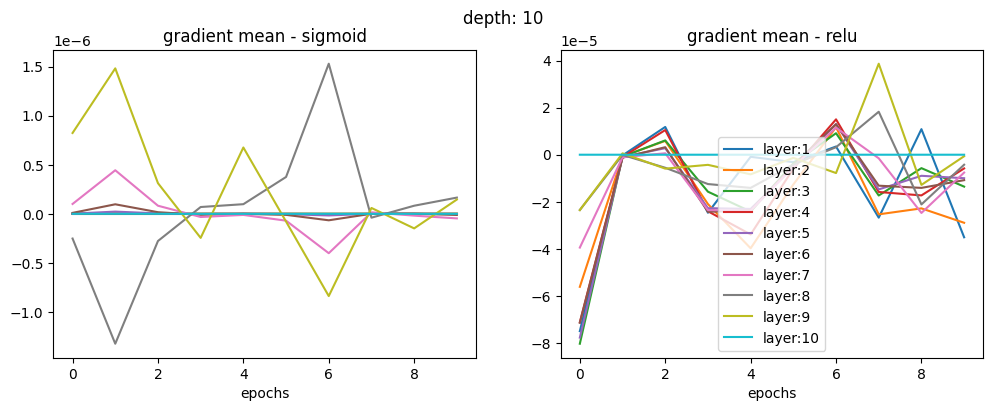

In [239]:
for i, (grad_history, weight_history) in enumerate(zip(grads_hist_depthwise_1, grads_hist_depthwise_2)):
    
    grads_mean = [[row[j][0].item() for j in range(len(row))] for row in grad_history]
    grads_std = [[row[j][1].item() for j in range(len(row))] for row in grad_history]

    weights_mean = [[row[j][0].item() for j in range(len(row))] for row in weight_history]
    weights_std = [[row[j][1].item() for j in range(len(row))] for row in weight_history]
    
    # grads_mean = [row[:-1] for row in grads_mean]
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    x_axis = list(range(num_epochs))
    ax[0].plot(x_axis, grads_mean)
    ax[1].plot(x_axis, weights_mean)

    ax[0].set_title('gradient mean - sigmoid')
    ax[1].set_title('gradient mean - relu')

    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')

    plt.suptitle('depth: ' + str(i+1))
    plt.legend(['layer:' + str(j+1) for j in range(len(grads_mean[0]))])
    plt.show()

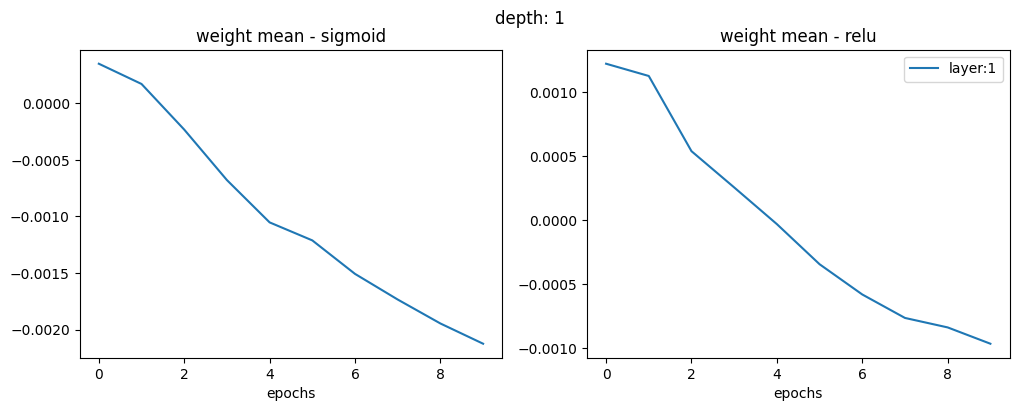

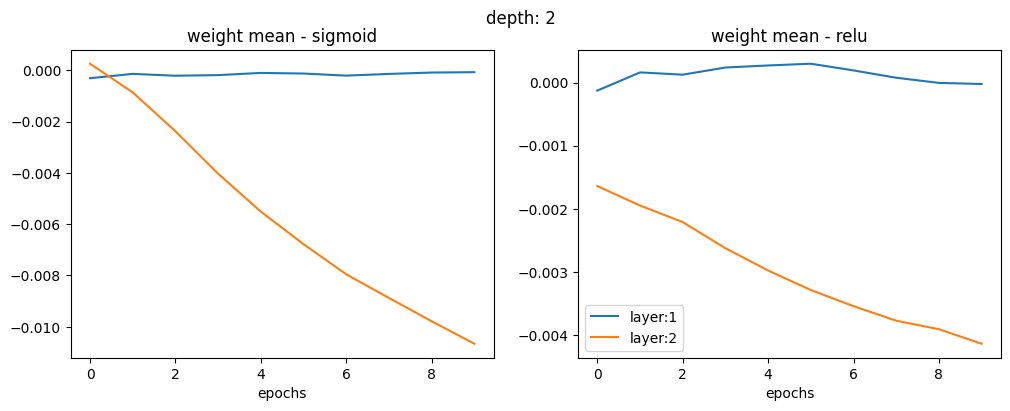

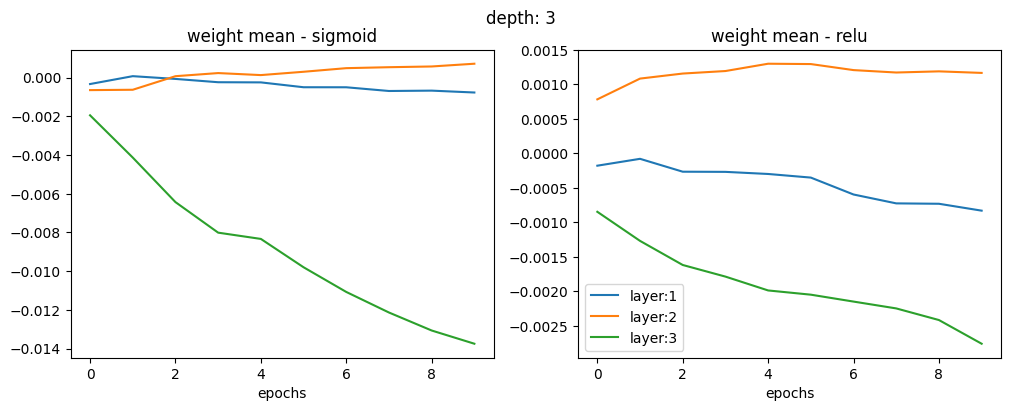

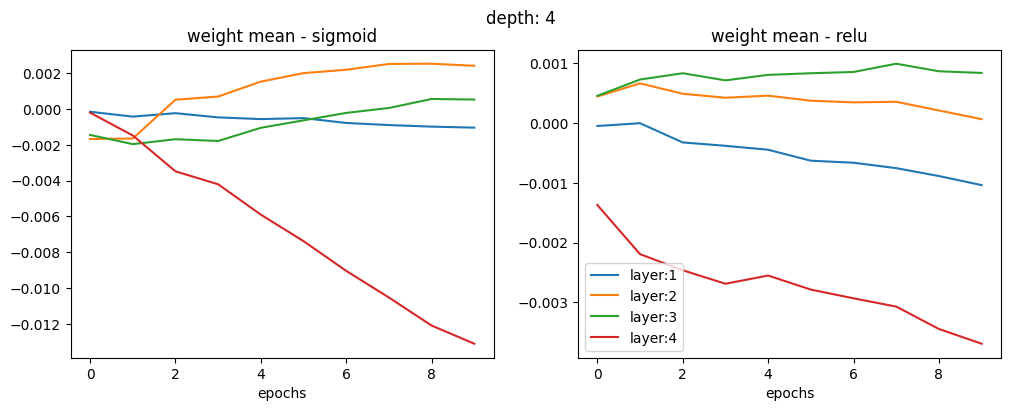

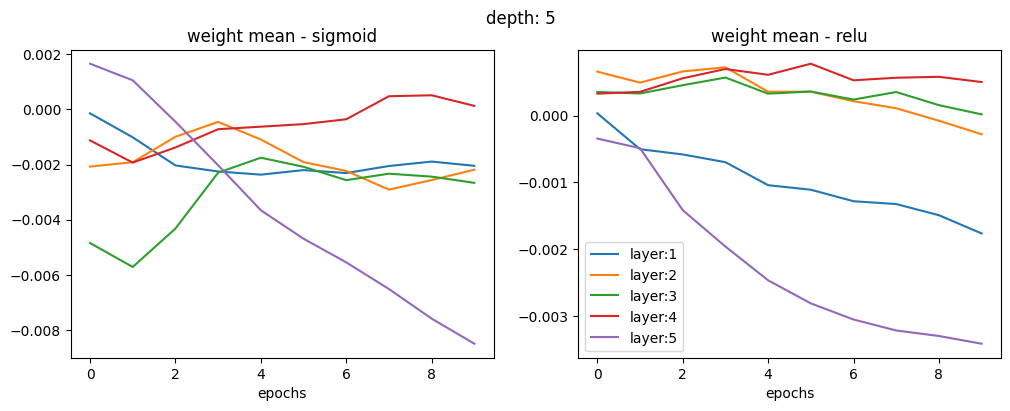

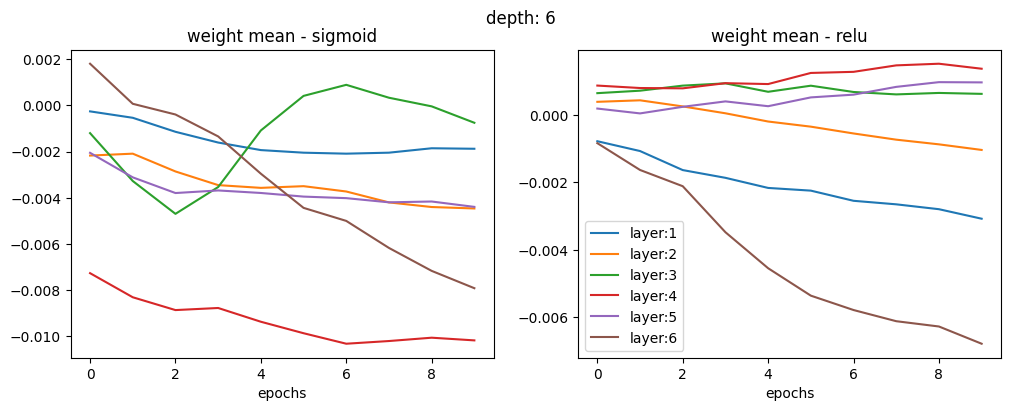

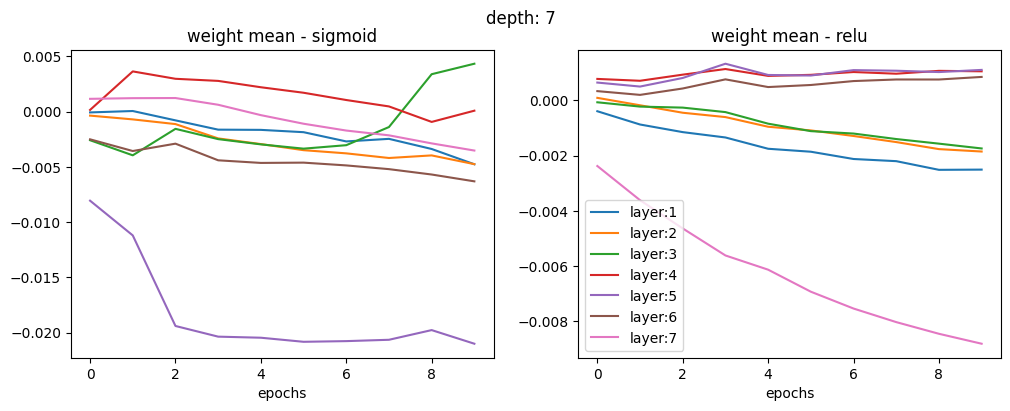

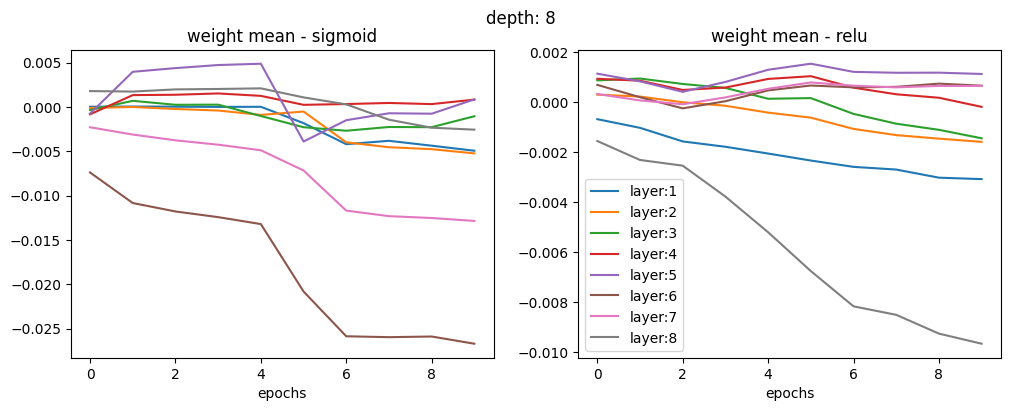

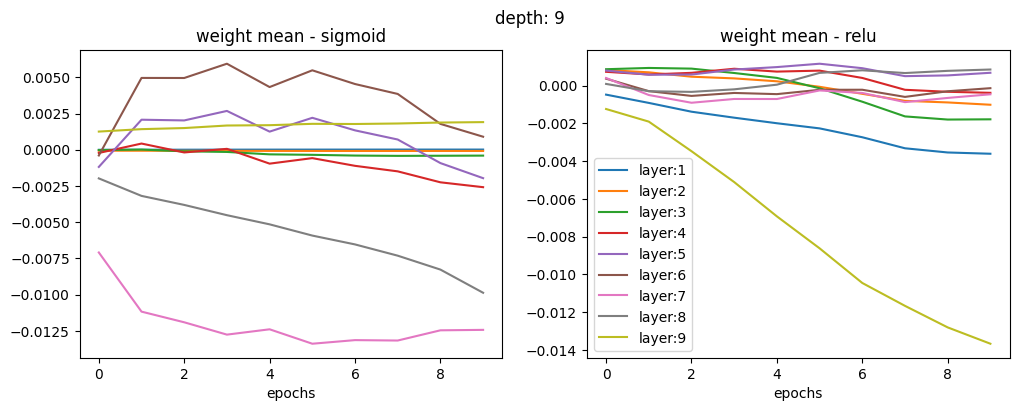

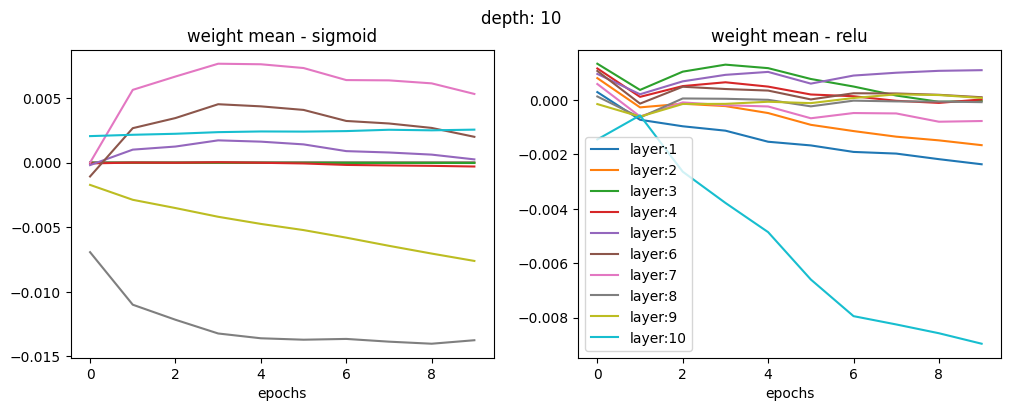

In [240]:
for i, (grad_history, weight_history) in enumerate(zip(weights_hist_depthwise_1, weights_hist_depthwise_2)):
    
    grads_mean = [[row[j][0].item() for j in range(len(row))] for row in grad_history]
    grads_std = [[row[j][1].item() for j in range(len(row))] for row in grad_history]

    weights_mean = [[row[j][0].item() for j in range(len(row))] for row in weight_history]
    weights_std = [[row[j][1].item() for j in range(len(row))] for row in weight_history]
    
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    x_axis = list(range(num_epochs))
    ax[0].plot(x_axis, grads_mean)
    ax[1].plot(x_axis, weights_mean)

    ax[0].set_title('weight mean - sigmoid')
    ax[1].set_title('weight mean - relu')

    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')

    plt.suptitle('depth: ' + str(i+1))
    plt.legend(['layer:' + str(j+1) for j in range(len(grads_mean[0]))])
    plt.show()

# Question 2

## import dataset

In [267]:
DATA = './GurNum/'
TRAIN = 'train'
VAL = 'val'

_tasks = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
    ])



trainset = torchvision.datasets.ImageFolder(root = DATA+TRAIN, transform = _tasks)
testset = torchvision.datasets.ImageFolder(root = DATA+VAL, transform = _tasks)

In [268]:
num_class_labels = len(trainset.classes)
img_size = torch.numel(trainset[0][0])

print(num_class_labels, img_size)

10 1024


### data summary

In [269]:
# dataset summary
print('trainset summary:', trainset, '\n\n')
print('valset summary:', testset, '\n\n')

trainset summary: Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ./GurNum/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) 


valset summary: Dataset ImageFolder
    Number of datapoints: 178
    Root location: ./GurNum/val
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) 




In [270]:
# 1k examples, 32x32 size, 1 channels (Gray)
# 178 examples, 32x32 size, 1 channels (Gray)
# 10 image classes
# print('trainset data shape:', trainset.data.shape)
# print('valset data shape:', valset.data.shape)
print('class labels', f'({len(trainset.classes)}):' , trainset.classes)

class labels (10): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [271]:
# 1k examples
# tuple -> (tensor, class label)
        # tensor -> image (1, 32, 32)

print('trainset length:', len(trainset))
print('1st trainset example:', trainset[0])
print('1st trainset tensor shape:', trainset[0][0].shape)

trainset length: 1000
1st trainset example: (tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)
1st trainset tensor shape: torch.Size([1, 32, 32])


## train-validation split

In [272]:
## train, validation split
val_fraction = 0.1

val_size = int(val_fraction * len(trainset))
train_size = len(trainset) - val_size

train_set, val_set = random_split(trainset, [train_size, val_size])


print('train_set size:', len(train_set), 'val_set size:', len(val_set))

train_set size: 900 val_set size: 100


## batch creation

In [273]:
# iterable batch creation
batch_kwargs = {
    'batch_size' : 1000, 
    'num_workers' : 0,
    'pin_memory' : True
}
train_loader = DataLoader(train_set, shuffle=True, **batch_kwargs)
val_loader = DataLoader(val_set, **batch_kwargs)
test_loader = DataLoader(testset, **batch_kwargs)

print('batch_params:', batch_kwargs)

batch_params: {'batch_size': 1000, 'num_workers': 0, 'pin_memory': True}


## regularization

### no reg

In [297]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

hl_data = (6, 256) # (no. hidden layers, no. neurons in each layer)
# no. of neurons in each hidden layer is same
activation = 'ReLU'
loss_fxn = nn.CrossEntropyLoss()
num_epochs = 150


no_reg_model = MLP(input_size, output_size, hl_data, activation).to(device)
print(no_reg_model)
no_reg_optimizer = optim.Adam(no_reg_model.parameters(), lr=1e-3)

no_reg_train_hist = fit(no_reg_model, device, train_loader, num_epochs, no_reg_optimizer, loss_fxn, val_loader)

MLP(
  (activation): ReLU()
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_feat

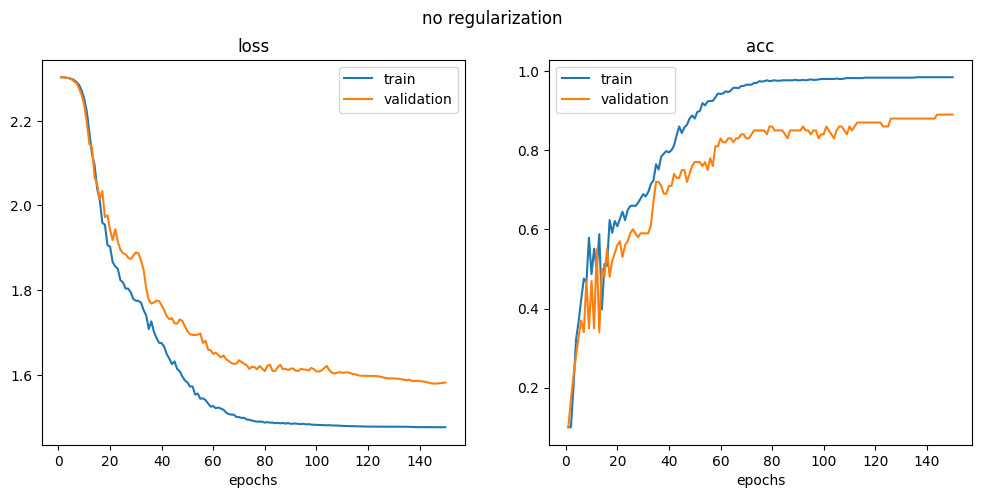

In [298]:
x_axis = list(range(1, num_epochs+1))
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_axis, no_reg_train_hist[0])
ax[1].plot(x_axis, no_reg_train_hist[1])
ax[0].plot(x_axis, no_reg_train_hist[2])
ax[1].plot(x_axis, no_reg_train_hist[3])

ax[0].set_title('loss')
ax[1].set_title('acc')

ax[0].legend(['train', 'validation'])
ax[1].legend(['train', 'validation'])


ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.suptitle('no regularization')

plt.show()

### l1 reg.

In [316]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

hl_data = (6, 256) # (no. hidden layers, no. neurons in each layer)
# no. of neurons in each hidden layer is same
loss_fxn = nn.CrossEntropyLoss()
num_epochs = 150

#  activations comparision
activation = 'ReLU'


l1_model = MLP(input_size, output_size, hl_data, activation).to(device)
print(l1_model)
l1_optimizer = optim.Adam(l1_model.parameters(), lr=1e-3)

l1_train_hist = fit(l1_model, device, train_loader, num_epochs, l1_optimizer, loss_fxn, val_loader, reg_fxn = lp_norm_reg, reg_p_norm = 1, reg_lambda = 1e-3)

MLP(
  (activation): ReLU()
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_feat

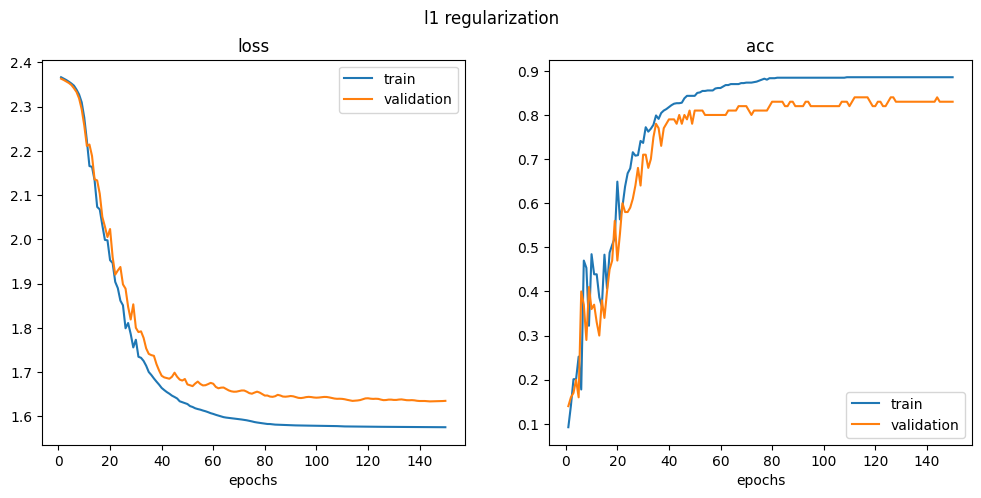

In [317]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(list(range(1, num_epochs+1)), l1_train_hist[0])
ax[1].plot(list(range(1, num_epochs+1)), l1_train_hist[1])
ax[0].plot(list(range(1, num_epochs+1)), l1_train_hist[2])
ax[1].plot(list(range(1, num_epochs+1)), l1_train_hist[3])

ax[0].set_title('loss')
ax[1].set_title('acc')

ax[0].legend(['train', 'validation'])
ax[1].legend(['train', 'validation'])


ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.suptitle('l1 regularization')

plt.show()

### l2 reg.

In [318]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

hl_data = (6, 256) # (no. hidden layers, no. neurons in each layer)
# no. of neurons in each hidden layer is same
loss_fxn = nn.CrossEntropyLoss()
num_epochs = 150

#  activations comparision
activation = 'ReLU'


l2_model = MLP(input_size, output_size, hl_data, activation).to(device)
print(l2_model)
l2_optimizer = optim.Adam(l2_model.parameters(), lr=1e-3)

l2_train_hist = fit(l2_model, device, train_loader, num_epochs, l2_optimizer, loss_fxn, val_loader, reg_fxn = lp_norm_reg, reg_p_norm = 2, reg_lambda = 1)

MLP(
  (activation): ReLU()
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_feat

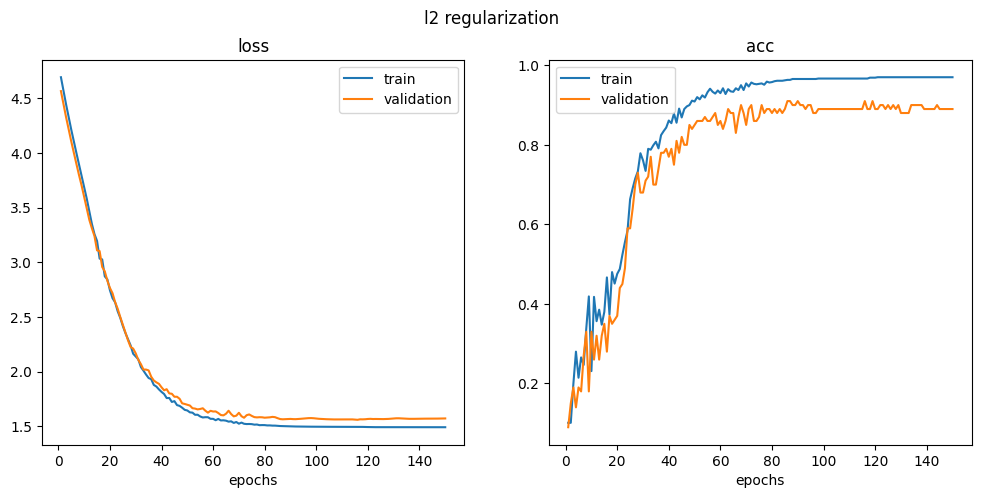

In [319]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(list(range(1, num_epochs+1)), l2_train_hist[0])
ax[1].plot(list(range(1, num_epochs+1)), l2_train_hist[1])
ax[0].plot(list(range(1, num_epochs+1)), l2_train_hist[2])
ax[1].plot(list(range(1, num_epochs+1)), l2_train_hist[3])

ax[0].set_title('loss')
ax[1].set_title('acc')

ax[0].legend(['train', 'validation'])
ax[1].legend(['train', 'validation'])


ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.suptitle('l2 regularization')

plt.show()

### dropout reg

In [320]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

hl_data = (6, 256) # (no. hidden layers, no. neurons in each layer)
# no. of neurons in each hidden layer is same
loss_fxn = nn.CrossEntropyLoss()
num_epochs = 150

#  activations comparision
activation = 'ReLU'


drop_model = MLP(input_size, output_size, hl_data, activation, dropout_prob = 0.2).to(device)
print(drop_model)
drop_optimizer = optim.Adam(drop_model.parameters(), lr=1e-3)

drop_train_hist = fit(drop_model, device, train_loader, num_epochs, drop_optimizer, loss_fxn, val_loader)

MLP(
  (activation): ReLU()
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_feat

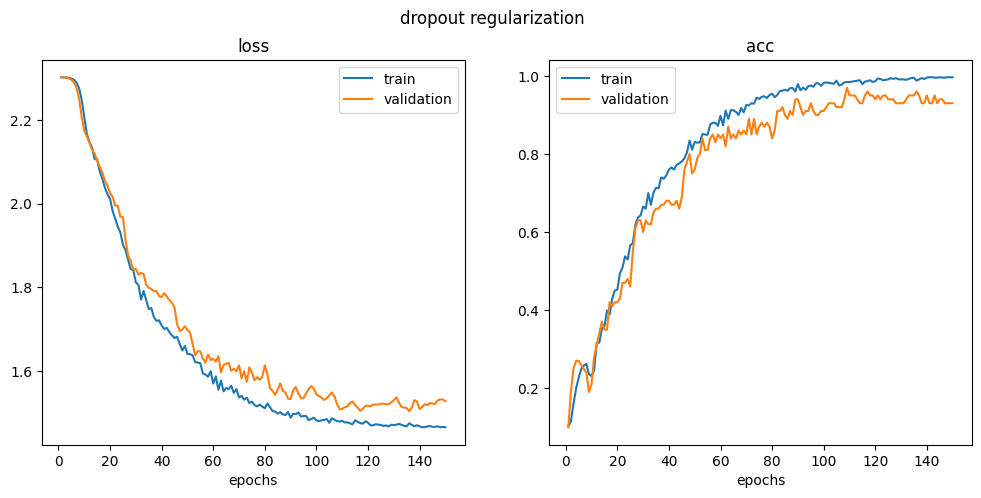

In [321]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(list(range(1, num_epochs+1)), drop_train_hist[0])
ax[1].plot(list(range(1, num_epochs+1)), drop_train_hist[1])
ax[0].plot(list(range(1, num_epochs+1)), drop_train_hist[2])
ax[1].plot(list(range(1, num_epochs+1)), drop_train_hist[3])

ax[0].set_title('loss')
ax[1].set_title('acc')

ax[0].legend(['train', 'validation'])
ax[1].legend(['train', 'validation'])


ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.suptitle('dropout regularization')

plt.show()